In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import time
import bisect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Callable
import itertools

from scipy.stats import mannwhitneyu, kstest

from gcdyn import bdms, mutators, poisson
import modulators
import my_bdms
import utils

In [3]:
expected_ntips_obs = 100
expected_ntips_unobs = 1000

λ = 1
t_min = 0.0
t_max = np.log(expected_ntips_unobs)/λ
dt = .01

rho0 = min(expected_ntips_obs / np.exp(λ*t_max), 1)
print(f"Sampling probability = {rho0}")
print(f"Expected (observed) number of tips = {rho0 * np.exp(λ*t_max)}")
print(f"Expected (unobserved) number of tips = {np.exp(λ*t_max)}")

Sampling probability = 0.10000000000000002
Expected (observed) number of tips = 100.0
Expected (unobserved) number of tips = 999.9999999999998


In [4]:
state_space = np.array([1])

birth_rates = np.array([λ])
death_rates = np.array([.00000000001])
mutation_rates = np.array([.00000000001])

transition_matrix = np.array([[1.0]])

rhos = np.array([rho0])

In [5]:
my_modulator = modulators.FEModulator(
    state_space,
    birth_rates,
    death_rates,
    mutation_rates,
    transition_matrix,
    rhos,
    t_min,
    t_max,
    dt,
)


In [8]:
my_birth_response = my_bdms.CustomResponse(my_modulator.λ,my_modulator.Λ,my_modulator.Λ_inv)
death_response = poisson.ConstantResponse(0.00000000001)
mutation_response = poisson.ConstantResponse(0.00000000001)
mutator = mutators.DiscreteMutator(state_space=state_space,transition_matrix=transition_matrix)

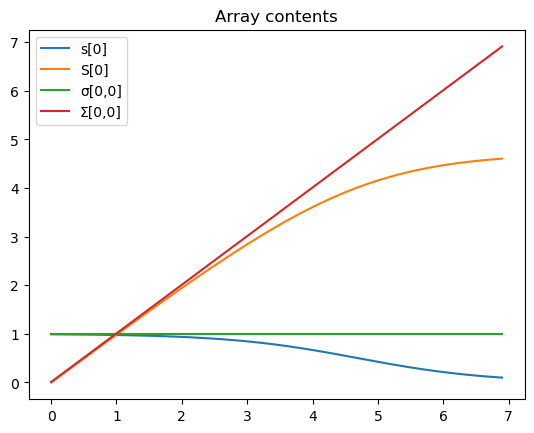

In [9]:
plt.figure();
for i in range(my_modulator.state_space.size):
    plt.plot(my_modulator.t_arr,my_modulator.s_arr[i,:],label=f's[{i}]');
    plt.plot(my_modulator.t_arr,my_modulator.S_arr[i,:],label=f'S[{i}]');
for i in range(my_modulator.state_space.size):
    for j in range(my_modulator.state_space.size):
        plt.plot(my_modulator.t_arr,my_modulator.σ_arr[i,j,:],label=f'σ[{i},{j}]');
        plt.plot(my_modulator.t_arr,my_modulator.Σ_arr[i,j,:],label=f'Σ[{i},{j}]');
plt.legend();
plt.title("Array contents");

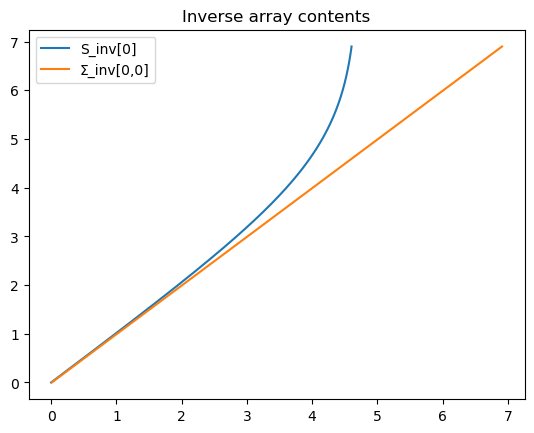

In [10]:
plt.figure();
for i in range(my_modulator.state_space.size):
    plt.plot(my_modulator.S_equispaced[i,:],my_modulator.S_inv_arr[i,:],label=f'S_inv[{i}]');
for i in range(my_modulator.state_space.size):
    for j in range(my_modulator.state_space.size):
        plt.plot(my_modulator.Σ_equispaced[i,j,:],my_modulator.Σ_inv_arr[i,j,:],label=f'Σ_inv[{i},{j}]');
plt.legend();
plt.title("Inverse array contents");

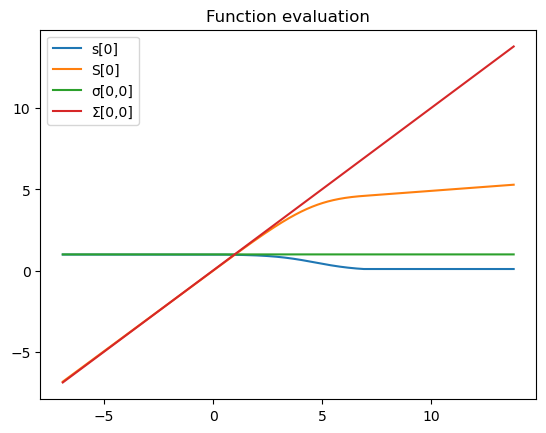

In [11]:
t_arr_big = np.arange(2*my_modulator.t_min - my_modulator.t_max,2*my_modulator.t_max - my_modulator.t_min,my_modulator.dt)
plt.figure();
for i in range(my_modulator.state_space.size):
    plt.plot(t_arr_big,[my_modulator._s(t,my_modulator.state_space[i]) for t in t_arr_big],label=f's[{i}]');
    plt.plot(t_arr_big,[my_modulator._S(t,my_modulator.state_space[i]) for t in t_arr_big],label=f'S[{i}]');
for i in range(my_modulator.state_space.size):
    for j in range(my_modulator.state_space.size):
        plt.plot(t_arr_big,[my_modulator._σ(t,my_modulator.state_space[i],my_modulator.state_space[j]) for t in t_arr_big],label=f'σ[{i},{j}]');
        plt.plot(t_arr_big,[my_modulator._Σ(t,my_modulator.state_space[i],my_modulator.state_space[j]) for t in t_arr_big],label=f'Σ[{i},{j}]');
plt.legend();
plt.title("Function evaluation");

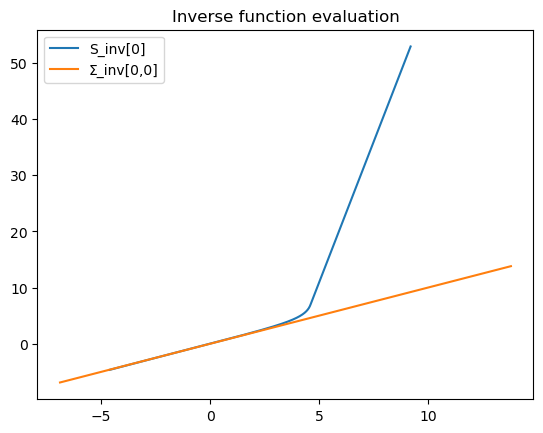

In [12]:
plt.figure();
for i in range(my_modulator.state_space.size):
    S_arr_big = np.arange(2 * my_modulator.S_equispaced[i,0] - my_modulator.S_equispaced[i,-1],2 * my_modulator.S_equispaced[i,-1] - my_modulator.S_equispaced[i,0],(my_modulator.S_equispaced[i,1] - my_modulator.S_equispaced[i,0])/2)
    plt.plot(S_arr_big,[my_modulator._S_inv(S,my_modulator.state_space[i]) for S in S_arr_big],label=f'S_inv[{i}]');
for i in range(my_modulator.state_space.size):
    for j in range(my_modulator.state_space.size):
        Σ_arr_big = np.arange(2 * my_modulator.Σ_equispaced[i,j,0] - my_modulator.Σ_equispaced[i,j,-1],2 * my_modulator.Σ_equispaced[i,j,-1] - my_modulator.Σ_equispaced[i,j,0],(my_modulator.Σ_equispaced[i,j,1] - my_modulator.Σ_equispaced[i,j,0])/2)
        plt.plot(Σ_arr_big,[my_modulator._Σ_inv(Σ,my_modulator.state_space[i],my_modulator.state_space[j]) for Σ in Σ_arr_big],label=f'Σ_inv[{i},{j}]');
plt.legend();
plt.title("Inverse function evaluation");

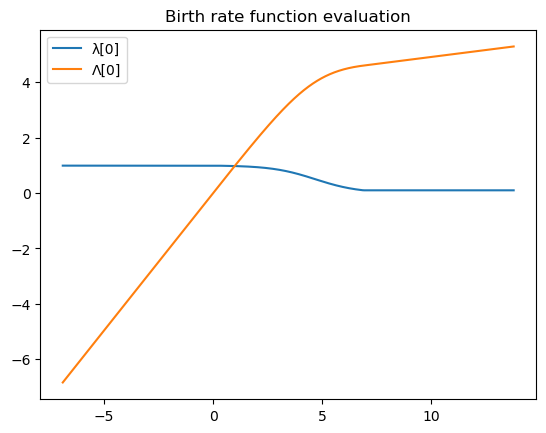

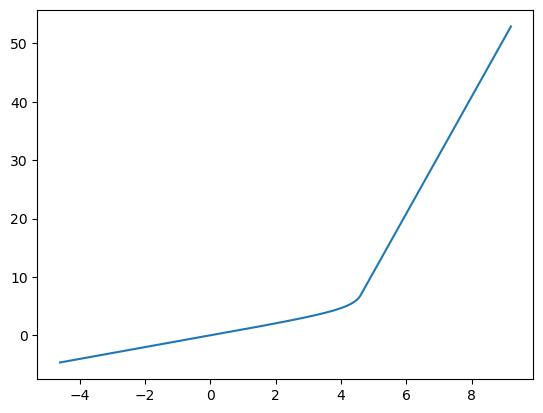

In [13]:
t_arr_big = np.arange(2*my_modulator.t_min - my_modulator.t_max,2*my_modulator.t_max - my_modulator.t_min,my_modulator.dt)
tree = bdms.TreeNode()
tree.x = 1

plt.figure();
for i in range(my_modulator.state_space.size):
    plt.plot(t_arr_big,[my_birth_response.λ(tree,t) for t in t_arr_big],label=f'λ[{i}]');
    plt.plot(t_arr_big,[my_birth_response.Λ(tree,t) for t in t_arr_big],label=f'Λ[{i}]');
plt.legend();
plt.title("Birth rate function evaluation");

plt.figure();
for i in range(my_modulator.state_space.size):
    S_arr_big = np.arange(2 * my_modulator.S_equispaced[i,0] - my_modulator.S_equispaced[i,-1],2 * my_modulator.S_equispaced[i,-1] - my_modulator.S_equispaced[i,0],(my_modulator.S_equispaced[i,1] - my_modulator.S_equispaced[i,0])/2)
    plt.plot(S_arr_big,[my_birth_response.Λ_inv(tree,S) for S in S_arr_big],label=f'Λ_inv[{i}]');